In [1]:
import torch
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import numpy as np
from tqdm.notebook import tqdm

This is mostly just to confirm for myself that the RoPE implementation with the `rotate_half` function works the same as the interleaved implementation

In [2]:
# torch input simulation
BATCHSIZE = 1
SEQLEN = 100
NUMHEADS = 1
D = 4

In [3]:
def rotate_half(x, interleaved=False):
    # from esm3
    if not interleaved:
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat((-x2, x1), dim=-1)
    else:
        x1, x2 = x[..., ::2], x[..., 1::2]
        return rearrange(
            torch.stack((-x2, x1), dim=-1), "... d two -> ... (d two)", two=2
        )

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|          | 0/99 [00:00<?, ?it/s]

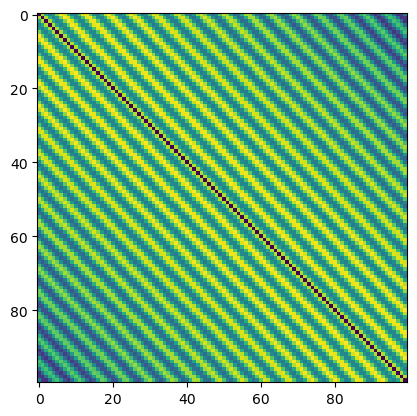

In [4]:
def apply_rot_pos_emb_fused_loc(ndx1, ndx2):
    x = torch.zeros((BATCHSIZE, SEQLEN, NUMHEADS, D))
    x[0, ndx1, 0] = torch.arange(D)
    x[0, ndx2, 0] = torch.arange(D)
    inv_freq = 1.0 / (10000 ** (torch.arange(0, D, 2).float() / D))
    t = torch.arange(x.shape[1])
    freqs = torch.outer(t, inv_freq)
    cos = repeat(freqs.cos(), "s d -> s 1 (2 d)") # shape (s, 1, d)
    sin = repeat(freqs.sin(), "s d -> s 1 (2 d)")


    emb = x*cos + rotate_half(x)*sin
    #print(x)
    return torch.dot(emb[0, ndx1,0], emb[0, ndx2,0])

a = np.zeros((SEQLEN, SEQLEN))
print(a)
for i in tqdm(range(SEQLEN-1)):
    for j in range(i+1, SEQLEN):
        a[i, j] = apply_rot_pos_emb_fused_loc(i, j)
a += a.T

plt.imshow(a)
plt.show()

And for some reason couldn't get the interleaved version to work 